# Stress Prediction Model using LightGBM

This notebook trains a LightGBM multiclass classifier to predict next-day stress levels using sleep, activity, physiological signals, and previous-day activity features. Time-series cross-validation provides evaluation, while SHAP (via LightGBM contributions) explains the model. It also saves the model, SHAP values, and dashboard data for interactive dashboards.

## Overview

1. **Data Loading & Preprocessing:** Load and clean Oura Ring data from CSV files, shift previous-day activity to align with today’s stress, and prepare the feature matrix and target.
2. **Exploratory Data Analysis:** Visualize feature correlations with a heatmap to identify relationships among variables.
3. **Baseline Models:** Evaluate RandomForest and Logistic Regression classifiers as baselines using weighted F1 scores.
4. **Class-Weighted LightGBM:** Train a LightGBM model that accounts for class imbalance by applying inverse-frequency class weights.
5. **t-SNE Visualization:** Project high-dimensional features to 2D using t-SNE and visualize clusters of stress levels.

In [28]:
# Imports

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style='whitegrid')

In [29]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path('/Users/nataliatabja/Documents/5th Year Summer/ML Projects/oura-project/data')

oura_stats = pd.read_csv(DATA_DIR / 'oura_stats.csv', parse_dates=['day'])
sleep     = pd.read_csv(DATA_DIR / 'sleep_2024-12-25_2025-08-23.csv',   parse_dates=['day'])
activity  = pd.read_csv(DATA_DIR / 'dailyactivity_2024-12-25_2025-08-23.csv', parse_dates=['day'])
sp02      = pd.read_csv(DATA_DIR / 'dailyspo2_2024-12-25_2025-08-23.csv',     parse_dates=['day'])
stress    = pd.read_csv(DATA_DIR / 'dailystress_2024-12-25_2025-08-23.csv',   parse_dates=['day'])


In [30]:
# Preprocess dataset

def snake(col):
    return col.lower().replace(' ', '_')

# Rename columns and select relevant features
sleep = sleep.rename(columns=snake)[['day', 'rem_sleep_duration', 'deep_sleep_duration', 'total_sleep_duration']]
activity = activity.rename(columns=snake)[['day', 'steps', 'high_activity_time', 'medium_activity_time', 'sedentary_time',
                                            'inactivity_alerts', 'active_calories', 'score']]
oura_stats = oura_stats.rename(columns=snake)[['day', 'temperature_trend_deviation', 'average_hrv',
                                               'average_resting_heart_rate', 'respiratory_rate']]
sp02 = sp02.rename(columns=snake)[['day', 'spo2_percentage']]
stress = stress.rename(columns=snake)[['day', 'day_summary']]

# Shift previous day's activity to align with today's stress
yest_activity = activity.copy()
yest_activity['day'] = yest_activity['day'] + pd.Timedelta(days=1)

# Merge all tables on day
merged = (sleep.merge(oura_stats, on='day')
                 .merge(sp02, on='day')
                 .merge(yest_activity, on='day')
                 .merge(stress, on='day'))

# Encode target labels
merged['target'] = merged['day_summary'].astype('category').cat.codes
class_names = list(merged['day_summary'].astype('category').cat.categories)

# Feature matrix and target vector
feature_cols = [c for c in merged.columns if c not in ['day', 'day_summary', 'target']]
X = merged[feature_cols].copy()
y = merged['target']

# Ensure numeric types and handle missing values
for col in ['temperature_trend_deviation', 'spo2_percentage']:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(X.mean())
print('Prepared feature matrix shape:', X.shape, ' Target shape:', y.shape)
print('Classes:', class_names)

Prepared feature matrix shape: (407, 15)  Target shape: (407,)
Classes: ['normal', 'restored', 'stressful']


In [31]:
# Prepare feature matrix and target vector
feature_cols = [col for col in merged.columns if col not in ['day', 'day_summary', 'target']]
X = merged[feature_cols].copy()
y = merged['target']

# 🔧 Fix dtypes and fill missing values
for col in ["temperature_trend_deviation", "spo2_percentage"]:
    X[col] = pd.to_numeric(X[col], errors="coerce")
X = X.fillna(X.mean())

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature columns:", X.columns.tolist())
print("Classes:", class_names)

X shape: (407, 15)
y shape: (407,)
Feature columns: ['rem_sleep_duration', 'deep_sleep_duration', 'total_sleep_duration', 'temperature_trend_deviation', 'average_hrv', 'average_resting_heart_rate', 'respiratory_rate', 'spo2_percentage', 'steps', 'high_activity_time', 'medium_activity_time', 'sedentary_time', 'inactivity_alerts', 'active_calories', 'score']
Classes: ['normal', 'restored', 'stressful']


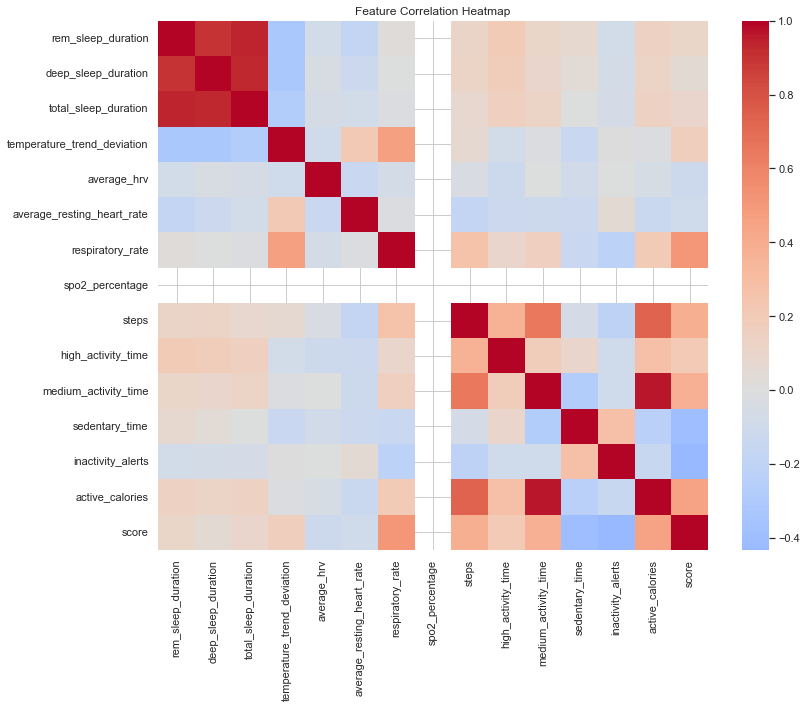

In [32]:
# Correlation Heatmap

# Compute correlation matrix
corr = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [33]:
# Baseline Models (RandomForest & LogisticRegression)

models = {
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
}

results = {}
ts_cv = TimeSeriesSplit(n_splits=5)

for name, model in models.items():
    scores = []
    for train_idx, test_idx in ts_cv.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        preds = model.predict(X.iloc[test_idx])
        scores.append(f1_score(y.iloc[test_idx], preds, average='weighted'))
    results[name] = np.mean(scores)

print('Baseline weighted F1 scores:')
for name, score in results.items():
    print(f'  {name}: {score:.3f}')

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [35]:
# LightGBM with Class Weights

# Compute class weights inversely proportional to class frequency
class_counts = y.value_counts().to_dict()
total = len(y)
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}

lgb_classifier = lgb.LGBMClassifier(objective='multiclass', n_estimators=200, random_state=42, class_weight=class_weights)

# Evaluate using time-series splits
f1_scores = []
for train_idx, test_idx in ts_cv.split(X):
    lgb_classifier.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = lgb_classifier.predict(X.iloc[test_idx])
    f1_scores.append(f1_score(y.iloc[test_idx], preds, average='weighted'))

print(f'LightGBM (class-weighted) mean weighted F1: {np.mean(f1_scores):.3f}')

LightGBM (class-weighted) mean weighted F1: 0.401


In [36]:
# t-SNE Visualization

from sklearn.preprocessing import StandardScaler

# Standardize features for t-SNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for lab in np.unique(y):
    plt.scatter(X_tsne[y==lab, 0], X_tsne[y==lab, 1], label=class_names[lab], alpha=0.6)
plt.legend(title='Stress Level')
plt.title('t-SNE Projection of Feature Space')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.tight_layout()
plt.show()

/Users/nataliatabja/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/nataliatabja/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/Users/nataliatabja/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [37]:
tscv = TimeSeriesSplit(n_splits=5)

preds_all = np.zeros(len(y))
probas     = None                    # allocate later

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = lgb.LGBMClassifier(objective='multiclass',
                               n_estimators=200,
                               random_state=42,
                               verbose=-1)
    model.fit(X_train, y_train)

    # ─── predictions ──────────────────────────────────────────────
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)          # shape = (len(test_idx), model.n_classes_)

    preds_all[test_idx] = preds

    # allocate probas once we know the true width
    if probas is None:
        num_classes = probs.shape[1]
        probas = np.zeros((len(y), num_classes))

    # if this fold has fewer columns (class absent in training set) pad with zeros
    if probs.shape[1] < probas.shape[1]:
        pad = probas.shape[1] - probs.shape[1]
        probs = np.hstack([probs, np.zeros((len(test_idx), pad))])

    # if this fold has more columns, extend the master array
    if probs.shape[1] > probas.shape[1]:
        pad = probs.shape[1] - probas.shape[1]
        probas = np.hstack([probas, np.zeros((len(y), pad))])

    probas[test_idx] = probs


In [38]:
# ——— Helper to make anything JSON‑serialisable ————————————————
def _json_safe(obj):
    import numpy as np
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    return str(obj)        # fallback for anything unexpected

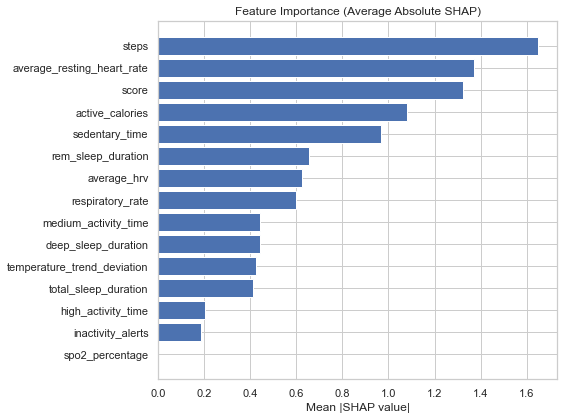

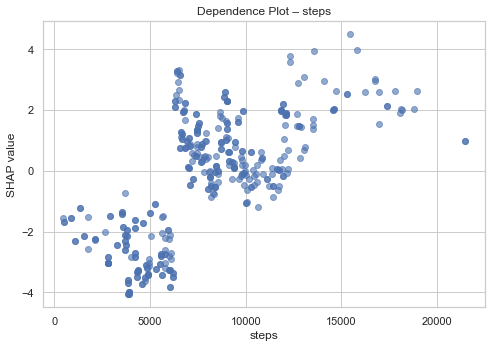

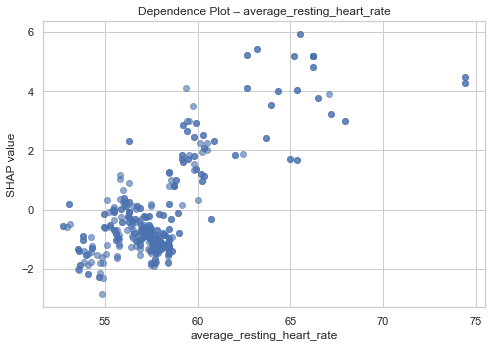

In [39]:
# ——— Train final model ——————————————————————————————————————————
final_model = lgb.LGBMClassifier(
    objective="multiclass",
    n_estimators=200,
    random_state=42,
    verbose=-1,
)
final_model.fit(X, y)

# ——— Synchronise class_names with what the model actually learned —— 
num_classes = final_model.n_classes_
if len(class_names) != num_classes:
    # 1) Try to recover from a pandas Categorical
    if isinstance(y, pd.Series) and hasattr(y, "cat"):
        class_names = list(y.cat.categories)
    else:                                   # 2) Fallback: numeric labels
        class_names = [str(c) for c in sorted(np.unique(y))]

# ——— SHAP values ————————————————————————————————————————————————
shap_raw = final_model.booster_.predict(X, pred_contrib=True)
# shape: (n_samples , num_classes * (n_features + 1))
shap_vals = shap_raw.reshape(len(X), num_classes, len(feature_cols) + 1)
shap_feature_vals = shap_vals.sum(axis=1)[:, :-1]   # drop bias term

# ——— Feature‑importance bar chart ————————————————————————————
mean_abs_shap = np.abs(shap_feature_vals).mean(axis=0)
order         = mean_abs_shap.argsort()[::-1]
ordered_names = [feature_cols[i] for i in order]
ordered_vals  = mean_abs_shap[order]

plt.figure(figsize=(8, 6))
plt.barh(ordered_names[::-1], ordered_vals[::-1])
plt.xlabel("Mean |SHAP value|")
plt.title("Feature Importance (Average Absolute SHAP)")
plt.tight_layout()
plt.show()

# ——— Dependence plots for the top‑2 features ——————————————
for feat in ordered_names[:2]:
    plt.figure(figsize=(7, 5))
    plt.scatter(merged[feat], shap_feature_vals[:, feature_cols.index(feat)], alpha=0.6)
    plt.xlabel(feat)
    plt.ylabel("SHAP value")
    plt.title(f"Dependence Plot – {feat}")
    plt.tight_layout()
    plt.show()

# ——— Save artefacts ——————————————————————————————————————————
final_model.booster_.save_model("model_lightgbm.json")

shap_dict = {
    "shap_values": shap_feature_vals,
    "feature_names": feature_cols,
    "dates": merged["day"].astype(str).tolist(),
    "class_names": class_names,
}
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_dict, f)

records = []
for i in range(len(merged)):
    rec = {
        "day": merged.iloc[i]["day"].strftime("%Y-%m-%d"),
        "features": {c: _json_safe(merged.iloc[i][c]) for c in feature_cols},
        "shap":     {feature_cols[j]: _json_safe(shap_feature_vals[i][j])
                     for j in range(len(feature_cols))},
        "actual":    class_names[int(y.iloc[i])],
        "predicted": class_names[int(preds_all[i])],
        "proba":     {class_names[j]: _json_safe(probas[i][j])
                      for j in range(num_classes)},
    }
    records.append(rec)

with open("dashboard_data.json", "w") as f:
    json.dump(records, f, indent=2, default=_json_safe)

In [40]:
# 🔁 Hyperparameter tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution for LightGBM
param_dist = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Initialise base classifier
lgb_classifier = lgb.LGBMClassifier(objective='multiclass', random_state=42, verbose=-1)
# Use a smaller TimeSeriesSplit for hyperparameter tuning
tscv_inner = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(
    estimator=lgb_classifier,
    param_distributions=param_dist,
    n_iter=10,
    cv=tscv_inner,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

# Fit the randomised search on the entire dataset
random_search.fit(X, y)
print('🎯 Best parameters:', random_search.best_params_)


🎯 Best parameters: {'num_leaves': 63, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05}


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        14
           0       0.56      0.69      0.62       217
           1       0.06      0.04      0.05        48
           2       0.31      0.20      0.25       128

    accuracy                           0.44       407
   macro avg       0.23      0.23      0.23       407
weighted avg       0.40      0.44      0.41       407



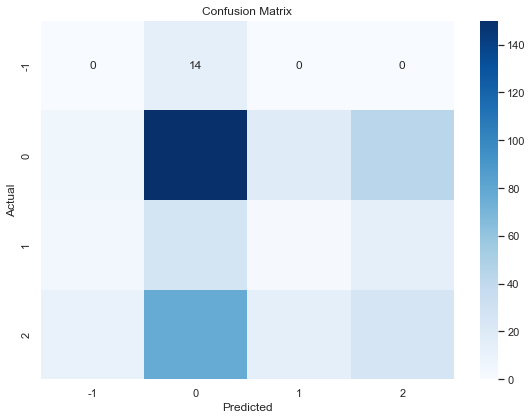

In [41]:
# 📊 Classification report and confusion matrix across all dates
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate a human-readable classification report
print(classification_report(y, preds_all, target_names=class_names))

# Compute confusion matrix
cm = confusion_matrix(y, preds_all)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [43]:
# 💾 Export predictions and probabilities to CSV for downstream analysis
output_df = pd.DataFrame({
    'day': merged['day'],
    'actual_label': [class_names[int(a)] for a in y],
    'predicted_label': [class_names[int(p)] for p in preds_all],
})

# Append predicted probabilities for each class
for i, cls in enumerate(class_names):
    # Ensure probabilities array exists and matches number of classes
    if probas is not None and i < probas.shape[1]:
        output_df[f'proba_{cls}'] = probas[:, i]
    else:
        # If probabilities missing for this class, fill with zeros
        output_df[f'proba_{cls}'] = 0.0

# Save to CSV
output_df.to_csv('model_predictions.csv', index=False)
print('✅ Saved model predictions to model_predictions.csv')


✅ Saved model predictions to model_predictions.csv
